This notebook begins by probing network and node level properties of highschool 2013 dataset.

Then proceeds to generate degrees and weights to create an upscaled network, weights are generated strangely with values between 1 and 2, degrees are assigned to nodes via the configuration model.

However, there is an error in assigning weights to the graph, which also prevents it properties from being probed. #BUG

Upscaled (500 nodes) network does not match analytical or original network (327 nodes) and shows much longer time till exponential growth that is characteristic of sigmoid, this could be due to the earlier #BUG which is infact twofold:

1. The weight generation is incorrect as this should be giving unormalised weights

2. The generated weights are not applied to the new graph - every edge has a weight of 1

This is not really a priority to fix however as it is working with SI model and out focus is SIR model

In [1]:
import network_manipulation as nm
import network_stats as ns
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import networkx as nx

dataset_paths = [
'Sociopatterns datasets/conference_2009.dat_',
'Sociopatterns datasets/highschool_2011.csv',
'Sociopatterns datasets/highschool_2012.csv',
'Sociopatterns datasets/highschool_2013.csv',
'Sociopatterns datasets/hospital_2010.dat_',
'Sociopatterns datasets/primaryschool_2014.csv',
'Sociopatterns datasets/workplace_2013.dat',
'Sociopatterns datasets/workplace_2015.dat_']

dataset_names = [
    'Conference 1', 
    'Highschool 1', 
    'Highschool 2', 
    'Highschool 3', 
    'Hospital 1', 
    'Primaryschool 1', 
    'Workplace 1', 
    'Workplace 2']

Node measures
degree : 35.584097859327215
weight : 32.400825025782055
closeness : 152.51139972965692
betweenness : 1.1665691363850876
eigenvector : 16.501379789393575


Network measures
nodes : 327
edges : 5818
ratio : 17.792048929663608
components : 1
density : 0.10915367441511416
path : 2.1594341569576554
diameter : 4
transitivity : 0.44442135612150807




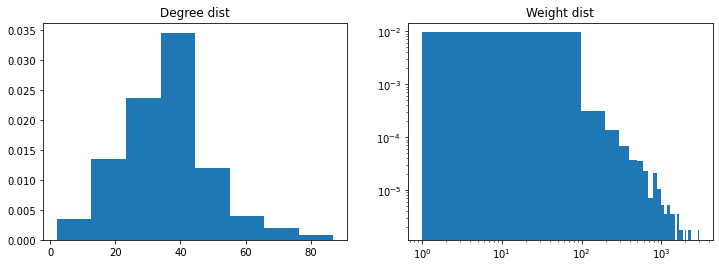

In [2]:
# Measuring original network

G = nm.build_nxgraph(dataset_paths[3], False) 
node_measures = ns.measure_nodes(G)
network_measures = ns.measure_network(G)

def print_dict(dict):
    for key in list(dict.keys()):
        print(key + ' : ' + str(dict[key]))
    print('\n')
        
print('Node measures')
print_dict(node_measures)
print('Network measures')
print_dict(network_measures)

degrees, weights = ns.analyse_graph(G)

figure, axis = plt.subplots(1, 2)
figure.set_figwidth(12)

axis[0].hist(degrees, bins = 8, density = 1)
axis[0].set_title('Degree dist')

axis[1].hist(weights, bins = 30, density = 1)
axis[1].set_title('Weight dist')
axis[1].set_xscale('log')
axis[1].set_yscale('log')
plt.show()

# Should also include plots of degree dist and weight dist

In [3]:
# For some reason this breaks when using normalizaed weights
# While logbinning the data, it complains about ydata not being defined
# This could be because the scale is designed to be calculated for un-normalized
# weights, so could fix by making log binning function account for norming

import scipy.stats as sps

dfit, dcov = ns.fit_degrees(degrees)

class degree_distribution(sps.rv_continuous): 
    def _pdf(self, x):
        return ns.degree_func(x, *dfit)

ddist = degree_distribution(a=0)
degree_samples = ddist.rvs(size = 500) # 1000 samples, 2.5x bigger for network[0]
degree_samples = np.ceil(degree_samples).astype(int)
degree_samples = [ds for ds in degree_samples if ds != 0] # removes any zeros

print(sum(degree_samples))
if sum(degree_samples)%2 != 0: # Ensures that there is enough half-edges to build the graph!
    degree_samples = np.append(degree_samples, 35) # chose this as seems to be average from graph
print(sum(degree_samples))

H = nx.configuration_model(degree_samples, create_using = nx.Graph)

/Users/ali/MSci Project/network_stats.py:104: RuntimeWarning: divide by zero encountered in true_divide
  return (x**a) / np.exp(b*x+c)
/Users/ali/MSci Project/network_stats.py:104: RuntimeWarning: overflow encountered in exp
  return (x**a) / np.exp(b*x+c)
/Users/ali/MSci Project/network_stats.py:104: RuntimeWarning: overflow encountered in double_scalars
  return (x**a) / np.exp(b*x+c)
/Users/ali/MSci Project/network_stats.py:104: RuntimeWarning: invalid value encountered in double_scalars
  return (x**a) / np.exp(b*x+c)
/Users/ali/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/Users/ali/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in _cdf_single (vectorize

17941
17976


In [4]:
scale, scale_err = ns.optimize_scale(weights)
wfit, wcov = ns.fit_weights(weights, scale)

class weight_distribution(sps.rv_continuous): 
    def _pdf(self, x):
        return ns.weight_func(x, *wfit)

w_func = weight_distribution(a=0)

H = ns.set_weights(H, w_func) 

/Users/ali/MSci Project/network_stats.py:89: RuntimeWarning: overflow encountered in exp
  return  b * ((x)**c) / np.exp(x*a)
/Users/ali/MSci Project/network_stats.py:89: RuntimeWarning: overflow encountered in power
  return  b * ((x)**c) / np.exp(x*a)
/Users/ali/MSci Project/network_stats.py:89: RuntimeWarning: divide by zero encountered in true_divide
  return  b * ((x)**c) / np.exp(x*a)
/Users/ali/MSci Project/network_stats.py:89: RuntimeWarning: overflow encountered in true_divide
  return  b * ((x)**c) / np.exp(x*a)
/Users/ali/MSci Project/network_stats.py:89: RuntimeWarning: overflow encountered in multiply
  return  b * ((x)**c) / np.exp(x*a)


  best scaling factor    best average error
---------------------  --------------------
                 2.89                  2.93


IndexError: list index out of range

In [8]:
H.edges()

EdgeView([(0, 85), (0, 376), (0, 150), (0, 439), (0, 12), (0, 71), (0, 205), (0, 258), (0, 54), (0, 452), (0, 344), (0, 415), (0, 88), (0, 66), (0, 456), (0, 458), (0, 3), (0, 325), (0, 379), (0, 158), (0, 119), (0, 91), (0, 434), (0, 194), (0, 117), (0, 141), (0, 395), (0, 67), (0, 230), (0, 424), (0, 175), (0, 123), (0, 328), (0, 303), (0, 455), (0, 341), (0, 140), (0, 406), (0, 363), (0, 300), (0, 121), (0, 188), (1, 215), (1, 240), (1, 86), (1, 115), (1, 458), (1, 204), (1, 100), (1, 49), (1, 421), (1, 155), (1, 453), (1, 157), (1, 91), (1, 327), (1, 111), (1, 324), (1, 354), (1, 447), (1, 428), (1, 451), (1, 283), (1, 26), (1, 101), (1, 247), (1, 269), (1, 158), (1, 321), (1, 408), (1, 181), (1, 415), (1, 21), (1, 120), (1, 370), (1, 308), (2, 110), (2, 74), (2, 144), (2, 243), (2, 100), (2, 19), (2, 142), (2, 352), (2, 31), (2, 391), (2, 135), (2, 168), (2, 402), (2, 25), (2, 76), (2, 325), (2, 216), (2, 26), (2, 241), (2, 184), (2, 334), (2, 360), (2, 320), (2, 385), (2, 306), (

In [13]:
H[0][12]['weight']

1

In [16]:
w_func = weight_distribution(a=1)
w_samples = w_func.rvs(size = 10)
print(w_samples)

[1.00007094 1.00008116 1.00002007 1.00011638 1.00009074 1.00005826
 1.00001389 1.00011841 1.0000915  1.0000095 ]


In [15]:
node_measures = ns.measure_nodes(H)
network_measures = ns.measure_network(H)

print('Node measures')
print_dict(node_measures)
print('Network measures')
print_dict(network_measures)

gen_degrees, gen_weights = ns.analyse_graph(H) # changed variable name to stop throwing off optimize_scale function

figure, axis = plt.subplots(1, 2)
figure.set_figwidth(12)

axis[0].hist(gen_degrees, bins = 8, density = 1)
axis[0].set_title('Degree dist')

axis[1].hist(gen_weights, bins = 30, density = 1)
axis[1].set_title('Weight dist')
axis[1].set_xscale('log')
axis[1].set_yscale('log')
plt.show()

KeyError: 'weight'

In [19]:
# Shows that extra components of generated graph are singular nodes (i don't know how
# this is happening in the configuration model), the number of extra components
# is equal to the number of times "what the dog doin is printed" which occurs when
# the graph has nodes with no connections, meaning the degree distribution is
# generating 0's so simply need to remove these.

components = list(nx.connected_components(H))
for component in components:
    print(len(component))


478


0
1
2
3
4


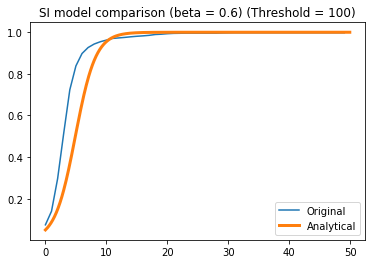

0
1
2
3
4


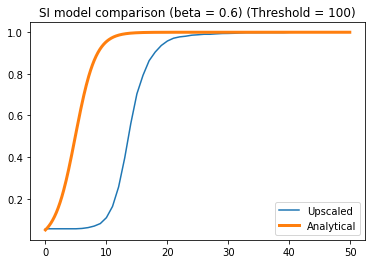

In [ ]:
import SI_model_nx as si

simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.6
simulation_params['Runs'] = 5
simulation_params['Threshold'] = 100
simulation_params['Increment'] = 0.1

si.SI_comparison(G, simulation_params, 'Original')
si.SI_comparison(H, simulation_params, 'Upscaled')